In [1]:
import keras

2024-03-15 17:12:19.305636: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 17:12:19.305771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 17:12:19.445518: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import numpy as np
import pandas as pd
from torch.utils import data
from scipy.signal import resample

class DataSet(data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.files = [file.path for file in os.scandir(self.root_dir) if file.name.endswith('.txt')]
        self.transform = transform

        # make sure in the data directory, this is the case as this is very specific indexing
        self.left_data = self.files[:20]
        self.right_data = self.files[20:]
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if idx < len(self.left_data):
            file_path = self.left_data[idx]
            label = 0  # left - class 0
        else:
            file_path = self.right_data[idx - len(self.left_data)]
            label = 1  # right - class 1
        
        # Reading data from file
        data = np.transpose(pd.read_csv(file_path, skiprows=5).iloc[1700:3500, 1:5].to_numpy())
        # downsampling
        data = resample(data, num=int(len(data[0]) * (512 / 800)), axis=1)

        # Applying any transformations if needed
        if self.transform:
            data = self.transform(data)

        return data, label


In [3]:
from torch.utils.data import DataLoader

dataset = DataSet(root_dir='/kaggle/input/trained-model/txt_data/txt_data', transform=None)

dataloader = DataLoader(dataset, batch_size=40, shuffle=True)
for data, labels in dataloader:
    outdata = data
    outlabels = labels


In [ ]:
left = []
right = []

for i, label in enumerate(outlabels):
    if label == 1:
        right.append(outdata[i])
    else:
        left.append(outdata[i])

left = np.array(left)
right = np.array(right)


In [18]:
left = left.reshape(-1,4,1536)
right = right.reshape(-1,4,1536)
print(left.shape)
print(right.shape)

(15, 4, 1536)
(15, 4, 1536)


In [21]:
interpolated_data = np.concatenate([left, right], axis=0)

In [23]:
outlabels = []
for i in range(20):
    outlabels.append(1)
for i in range(20):
    outlabels.append(0)
    

In [27]:
np.random.seed(42)  
outlabels = np.array(outlabels)

random_indices = np.random.permutation(len(interpolated_data)).astype(int)
shuffled_data = interpolated_data[random_indices]
shuffled_labels = outlabels[random_indices]

In [28]:
def filter(input_array, window_size):
    total = []
    window = window_size
    new_length = 0
    for i in range(len(input_array)):
        one_trail = []
        for k in range(len(input_array[i])):
            one_channel = []
            for y in range(len(input_array[i][k])):
                if y >= window:
                    sum = input_array[i][k][y-window:y].sum()
                    avg = sum / window
                    one_channel.append(avg)
            one_trail.append(one_channel)
            new_length = len(one_channel)
        total.append(one_trail)
    return total, new_length


In [29]:
# left, new_timesteps = filter(left, 32)
# right, new_timesteps = filter(right, 32)
filtered, new_timesteps = filter(shuffled_data, 32)

In [30]:
def reshape(input_array):
    output_array = [] 
    
    for i in range(len(input_array)):
        each_trail = []
        before_trans = np.array(input_array[i])
        output_array.append(before_trans.transpose())
    return output_array

In [31]:
# right = reshape(right) #reshape array for the network
# left = reshape(left)
reshaped = reshape(filtered)

In [32]:
from sklearn.preprocessing import StandardScaler
def normalize(input_data):
    output_data = []
    for i in range(len(input_data)):
        scaler = StandardScaler()
        scaler.fit(input_data[i])
        scaled_X = scaler.transform(input_data[i])
        output_data.append(scaled_X)
    return output_data

In [33]:
# left = normalize(left)
# right = normalize(right)
normalized = normalize(reshaped)

In [34]:
normalized = np.array(normalized)
outlabels = np.array(outlabels)
print(normalized.shape)
print(outlabels.shape)

(30, 1504, 4)
(30,)


In [36]:
data_X = np.transpose(normalized, (0, 2, 1))
data_X = np.expand_dims(data_X, axis=-1)


In [37]:
print(data_X.shape)
print(outlabels.shape)

(30, 4, 1504, 1)
(30,)


### Build the EEGNet model

In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, DepthwiseConv2D, Activation, AveragePooling2D, Flatten, Dense
from tensorflow.keras.layers import Dropout, SpatialDropout2D, SeparableConv2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import SGD
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameter as hp
from tensorflow.keras.callbacks import EarlyStopping
def build_eegnet_model(hp):
    Chans = 4
    Samples = 1504
    nb_classes = 2  # You need to specify the correct number of classes
    dropoutRate = hp['dropout_rate']  # Access directly from the dictionary
    kernLength = hp['kern_length']
    F1 = hp['F1']
    D = hp['D']
    norm_rate = hp['norm_rate']
    F2 = F1 * D
    
    if hp['dropout_type'] == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    else:
        dropoutType = Dropout

    input1 = Input(shape=(Chans, Samples, 1))

    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, depthwise_constraint=max_norm(1.))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = dropoutType(dropoutRate)(block1)

    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = dropoutType(dropoutRate)(block2)

    flatten = Flatten(name='flatten')(block2)

    dense = Dense(nb_classes, name='dense', kernel_constraint=max_norm(norm_rate))(flatten)
    softmax = Activation('softmax', name='softmax')(dense)

    model = Model(inputs=input1, outputs=softmax)

    sgd = SGD(learning_rate=hp['learning_rate'])
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    return model
# if the code only run once this is needed
# train_X = np.transpose(train_X, (0, 2, 1))
# train_X = np.expand_dims(train_X, axis=-1)
# test_X = np.transpose(test_X, (0, 2, 1))
# test_X = np.expand_dims(test_X, axis=-1)

# val_data = (test_X, test_label)

best_hyperparameters = {'dropout_rate': 0.2, 'kern_length': 64, 'F1': 40, 'D': 2, 'norm_rate': 0.1, 'dropout_type': 'Dropout', 'learning_rate': 7.257330368974151e-05}

best_model = build_eegnet_model(hp=best_hyperparameters)
best_model.load_weights('/kaggle/input/trained-model/checkpoint.weights.h5')
print('finished!')
# Assuming `best_model` is your trained model
evaluation_result = best_model.evaluate(data_X, shuffled_labels)

# Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# rnn = best_model.fit(train_X, train_label, epochs=50, validation_data=val_data, callbacks=[early_stopping] )



finished!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step - accuracy: 0.4333 - loss: 0.7054


W0000 00:00:1710526210.736702     602 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [41]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_X, test_X, train_labels, test_labels = train_test_split(data_X, shuffled_labels, test_size=0.2, random_state=42)
val_data = (test_X, test_labels)
# train_X and train_labels will contain 80% of the data for training
# test_X and test_labels will contain 20% of the data for testing

rnn = best_model.fit(train_X, train_labels, epochs=50, validation_data=val_data)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5000 - loss: 0.6897

W0000 00:00:1710526253.394723     599 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5000 - loss: 0.6897 - val_accuracy: 0.5000 - val_loss: 0.6687
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5417 - loss: 0.7013 - val_accuracy: 0.5000 - val_loss: 0.6668
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5833 - loss: 0.6881 - val_accuracy: 0.5000 - val_loss: 0.6652
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5000 - loss: 0.7040 - val_accuracy: 0.5000 - val_loss: 0.6635
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5417 - loss: 0.6924 - val_accuracy: 0.5000 - val_loss: 0.6620
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5000 - loss: 0.7021 - val_accuracy: 0.5000 - val_loss: 0.6603
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5417 - loss: 0.6892 - val_accuracy: 0.5000 - val_loss: 0.6587
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5833 - loss: 0.6906 - val_accuracy: 0.5000 - val_loss: 0.6573
Epoch 9/50
1/

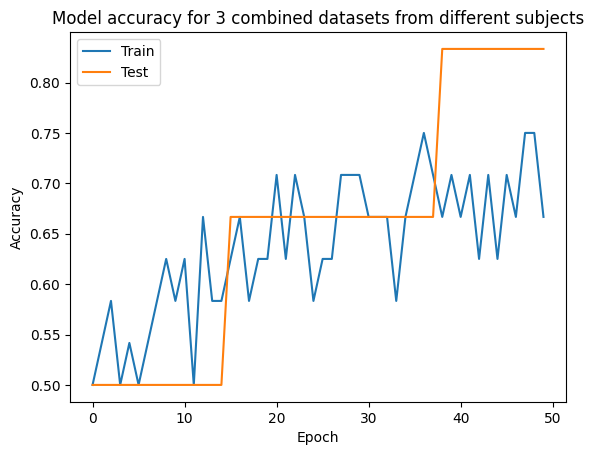

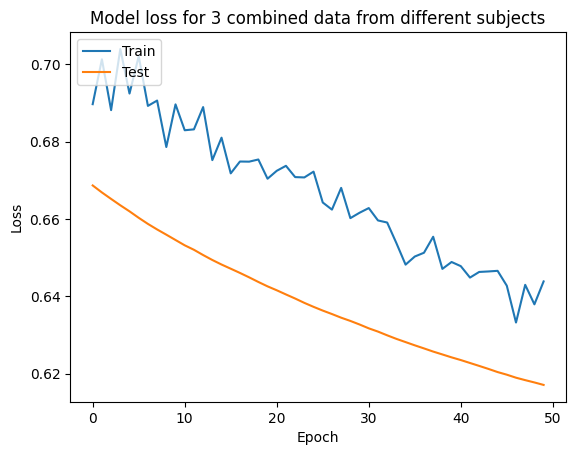

In [42]:
import matplotlib.pyplot as plt

#Visulize Result
# Plot training & validation accuracy values
plt.plot(rnn.history['accuracy'])
plt.plot(rnn.history['val_accuracy'])
plt.title('EEGNet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(rnn.history['loss'])
plt.plot(rnn.history['val_loss'])
plt.title('EEGNet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [43]:
test_accuracy = best_model.evaluate(val_data[0], val_data[1])[1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8333 - loss: 0.6171


In [44]:
best_model.save('trained_model.keras')